Sungjin KIM and Chiheb BEN SAID

In [439]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_1samp
from scipy.stats import norm

from sklearn.metrics import mean_squared_error

import datetime
from workalendar.europe import France
cal = France()
%matplotlib inline

In [2]:
spot_data = pd.read_excel('donneesProjet3.xlsx',sheet_name='spot')
forward_data = pd.read_excel('donneesProjet3.xlsx',sheet_name='forward')
forward_return_data = pd.read_excel('donneesProjet3.xlsx',sheet_name='forward_return')

In [3]:
forward_data = forward_data.set_index(["Trade Date"])
forward_return_data = forward_return_data.set_index(["Trade Date"])

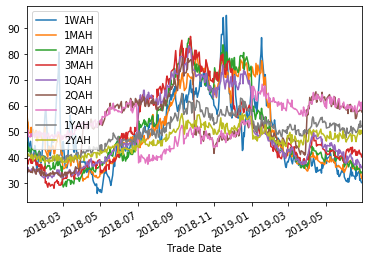

In [6]:
forward_data.plot()

## Empirical Motivation

In [7]:
pd_periode_index = forward_data.columns

In [8]:
pd_periode_columns = ["obs_vol"]

In [9]:
pd_periode = pd.DataFrame(columns=pd_periode_columns,index=pd_periode_index)

In [10]:
for idx,t in enumerate(pd_periode_index):
    pd_periode.iloc[idx,0] = pd.DataFrame.std(forward_return_data[t])

In [11]:
pd_periode

,obs_vol
1WAH,0.0808685
1MAH,0.0427178
2MAH,0.0422273
3MAH,0.0417557
1QAH,0.038012
2QAH,0.0459038
3QAH,0.0382278
1YAH,0.0318582
2YAH,0.032628


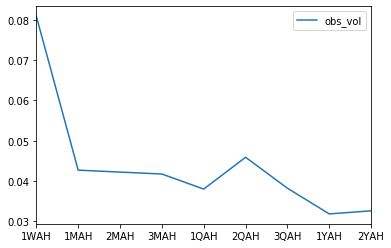

In [12]:
pd_periode.plot()

In [39]:
spot = pd.DataFrame(columns=["peak","off_peak"])

Get peak data

In [41]:
def get_date(date):
    yy = date.year
    mm = date.month
    dd = date.day
    return datetime.date(yy,mm,dd)

In [42]:
dates = spot_data["Trade Date"]
date = [get_date(d) for d in dates]
spot_data["Date"] = date 

In [44]:
spot["peak"] = spot_data.groupby(['Date'])['SPOT'].max()

Get off peak data, 1AM - 7AM

In [55]:
def get_off(date):
    return date.hour<8

In [58]:
off_peak = [get_off(d) for d in dates]
spot_data["off"] =  off_peak

In [64]:
spot["off_peak"] = spot_data[spot_data['off']==True].groupby(['Date'])['SPOT'].mean()

In [75]:
spot.index.name = 'Trade Date'

In [159]:
spot

,peak,off_peak
Trade Date,,
2018-01-01,23.875744,4.074772
2018-01-02,50.251126,14.260685
2018-01-03,36.651591,8.502717
2018-01-04,51.131565,11.682229
2018-01-05,56.170910,13.410169
...,...,...
2019-06-26,36.686531,24.713411
2019-06-27,43.481525,22.869853
2019-06-28,47.058353,24.973859


Use "1WAH" Forward as a over-the-counter price F(i)


Define descriptive statics for R(i) := ln S(i) - ln F(i)

In [88]:
dates = forward_data.index
date = [get_date(d) for d in dates]

In [89]:
forward_data.index = date 

In [94]:
forward_data.index.name = 'Trade Date'

In [99]:
data = pd.merge(spot, forward_data, on='Trade Date')

In [288]:
cols = ["Trade Date","spot_peak","spot_off_peak","forward","R_peak","R_off_peak"]

In [289]:
stat = pd.DataFrame(columns=cols)

In [290]:
stat["Trade Date"] = data.index
stat["spot_peak"] = np.array(data["peak"])
stat["spot_off_peak"] = np.array(data["off_peak"])
stat["forward"] = np.array(data["1WAH"])

In [291]:
spot

,peak,off_peak
Trade Date,,
2018-01-01,23.875744,4.074772
2018-01-02,50.251126,14.260685
2018-01-03,36.651591,8.502717
2018-01-04,51.131565,11.682229
2018-01-05,56.170910,13.410169
...,...,...
2019-06-26,36.686531,24.713411
2019-06-27,43.481525,22.869853
2019-06-28,47.058353,24.973859


In [292]:
stat["R_peak"] = np.log(stat["spot_peak"]) - np.log(stat["forward"])
stat["R_off_peak"] = np.log(stat["spot_off_peak"]) - np.log(stat["forward"])

In [293]:
summary_stat = pd.DataFrame(index=['D','E[R]','s.d.[R]','t-static'],columns=['peak','off_peak'])

In [294]:
summary_stat.loc['D','peak'] = len(stat.index)
summary_stat.loc['E[R]','peak'] = stat["R_peak"].mean()
summary_stat.loc['s.d.[R]','peak'] = stat["R_peak"].std()
summary_stat.loc['t-static','peak'] = ttest_1samp(stat["R_peak"], 0)[0]

summary_stat.loc['D','off_peak'] = len(stat.index)
summary_stat.loc['E[R]','off_peak'] = stat["R_off_peak"].mean()
summary_stat.loc['s.d.[R]','off_peak'] = stat["R_off_peak"].std()
summary_stat.loc['t-static','off_peak'] = ttest_1samp(stat["R_off_peak"], 0)[0]

In [295]:
summary_stat

,peak,off_peak
D,377,377
E[R],0.309657,-0.167928
s.d.[R],0.210704,0.282324
t-static,28.5351,-11.5491


## Single-Factor Market Model

We know the following system.
$$\frac{K_t}{K_t} = \nu dt + \sigma dW_t$$
$$\frac{dF(t,T_1,T_2)/F(t,T_1,T_2)}{dK_t/K_t} = c(t,T_1,T_2,\alpha) = \frac{e^{-\alpha(T_2-t)}(1-e^{(T_2-T_1+1)\alpha})}{(T_2-T_1)(1-e^\alpha )}$$

The parameter $\mu$ and $\sigma$ are estimated by least squares on the first equation, and $\alpha$ is estimated by minimizing the mean squared error of the difference between the left and right hand sides of the second equation.

Discretizing (with one unit of time between consecutive observations) gives $\Delta ln K_t = (\nu - \sigma^2 / 2) + \sigma \epsilon_t$, where $\epsilon_t$ is N(0,1)

We know that $\Delta ln K_t = R_t$.

In [307]:
R_peak = np.array(stat["R_peak"])
R_off_peak = np.array(stat["R_off_peak"])

In [308]:
parameters_peak = norm.fit(R_peak)
parameters_off_peak = norm.fit(off_peak)

In [309]:
sigma_peak = parameters_peak[1]
sigma_off_peak = parameters_off_peak[1]
nu_peak = parameters_peak[0] + sigma_peak**2 / 2
nu_off_peak = parameters_off_peak[0] + sigma_off_peak**2 /2
p_value_peak = ttest_1samp(R_peak,parameters_peak[0])[1]
p_value_off_peak = ttest_1samp(R_off_peak,parameters_off_peak[0])[1]

set $t_0 = 2018-01-01$ and $K_0=1$

In [504]:
columns = ['t','F_t','delta_F/F','K_peak_t','delta_K_peak/K_peak','K_off_peak_t','delta_K_off_peak/K_off_peak','T_1','T_2','forward_type','left_peak','left_off_peak']

In [505]:
data_for_estimate = pd.DataFrame(columns=columns)

In [506]:
forward_return_data = pd.read_excel('donneesProjet3.xlsx',sheet_name='forward_return')

In [507]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
    return next_month - datetime.timedelta(days=next_month.day)

def get_periode(date,periode):
    yy = date.year
    ww = date.isocalendar()[1]
    
    if periode == "1WAH":
        d = str(yy)+"-W"+str(ww+1)
        T1 = datetime.datetime.strptime(d + '-1', "%Y-W%W-%w")
        T2 = datetime.datetime.strptime(d + '-5', "%Y-W%W-%w")
        T1 = cal.find_following_working_day(T1)
        
    if periode == "1MAH":
        mm = date.month
        if mm+1 < 13:
            d = datetime.date(yy,mm+1,1)
        else :
            d = datetime.date(yy+1,1,1)
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(T1)        

        
    if periode == "2MAH":
        mm = date.month
        if mm+2 < 13:
            d = datetime.date(yy,mm+2,1)
        else :
            d = datetime.date(yy+1,(mm+2)%12,1)
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(T1) 
    
    if periode == "3MAH":
        mm = date.month
        if mm+3 < 13:
            d = datetime.date(yy,mm+3,1)
        else :
            d = datetime.date(yy+1,(mm+3)%12,1)
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(T1)
        
    if periode == "1QAH":
        q = int((date.month-1) / 3)+1
        if q < 4 :
            mm = (q)*3+1
            d = datetime.date(yy,mm,1)
            d2 = datetime.date(yy,mm+2,1)
        else :
            mm = 1
            d = datetime.date(yy+1,1,1)
            d2 = datetime.date(yy+1,3,1)
            
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(d2)

    if periode == "2QAH":
        q = int((date.month-1) / 3)+1
        if q < 3 :
            mm = (q+1)*3+1
            d = datetime.date(yy,mm,1)
            d2 = datetime.date(yy,mm+2,1)
        else :
            mm = ((q+1)*3+1)%12
            d = datetime.date(yy+1,mm,1)
            d2 = datetime.date(yy+1,mm+2,1)
            
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(d2)
        
    if periode == "3QAH":
        q = int((date.month-1) / 3)+1
        if q < 2 :
            mm = (q+2)*3+1
            d = datetime.date(yy,mm,1)
            d2 = datetime.date(yy,mm+2,1)
        else :
            mm = ((q+2)*3+1)%12
            d = datetime.date(yy+1,mm,1)
            d2 = datetime.date(yy+1,mm+2,1)
            
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(d2)
        
    if periode == "1YAH":
        d = datetime.date(yy+1,1,1)
        d2 = datetime.date(yy+1,12,31)
            
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(d2)
    
    if periode == "2YAH":
        d = datetime.date(yy+2,1,1)
        d2 = datetime.date(yy+2,12,31)
            
        T1 = cal.find_following_working_day(d)
        T2 = last_day_of_month(d2)    
    
    T1 = cal.find_following_working_day(T1)
    T2 = cal.find_following_working_day(T2)
    theta = cal.get_working_days_delta(T1,T2)
    return T1,T2,theta

In [508]:
def c(para):
    t = para[0]
    T1 = para[1]
    T2 = para[2]
    alpha = para[3]
    c = np.exp(-alpha*cal.get_working_days_delta(t,T2))*(1-np.exp(alpha*(cal.get_working_days_delta(T1,T2)+1)))/(cal.get_working_days_delta(T1,T2)*(1-np.exp(alpha)))
    if c > 100:
        print(t,T1,T2,alpha,para[4])
    return np.exp(-alpha*cal.get_working_days_delta(t,T2))*(1-np.exp(alpha*(cal.get_working_days_delta(T1,T2)+1)))/(cal.get_working_days_delta(T1,T2)*(1-np.exp(alpha)))

In [509]:
i = -1
K_peak = 1
K_off_peak = 1
for idx in range(1,len(forward_data.index)):
    t = forward_data.iloc[idx,:].name
    K_peak_before = K_peak
    K_off_peak_before = K_off_peak
    for col in range(len(forward_data.columns)):
        i = i+1
        F = np.array(stat[stat['Trade Date']==t]['forward'])[0]
        if forward_data.columns[col] == '1WAH':
            K_peak = K_peak * np.array(stat[stat['Trade Date']==t]['spot_peak'])[0] / F
            K_off_peak = K_off_peak * np.array(stat[stat['Trade Date']==t]['spot_off_peak'])[0] / F
            delta_K_peak = K_peak - K_peak_before
            delta_K_off_peak = K_off_peak - K_off_peak_before
            change_K_peak = delta_K_peak / K_peak
            change_K_off_peak = delta_K_off_peak / K_off_peak
            
        forward_type = col
        T1,T2,theta = get_periode(t,forward_data.columns[col])
#['t','F_t','delta_F/F','K_peak_t','delta_K_peak/K_peak','K_off_peak_t','delta_K_off_peak/K_off_peak','T_1','T_2','forward_type']
        change_F = np.array(forward_return_data[forward_return_data['Trade Date']==t][forward_data.columns[col]])[0]  
        left_peak = change_F / change_K_peak
        left_off_peak = change_F / change_K_off_peak
        data_for_estimate.loc[i] = [t,F,change_F,K_peak,change_K_peak,K_off_peak,change_K_off_peak,T1,T2,forward_type,left_peak,left_off_peak]
        
        

/Users/sungjinkim/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


In [510]:
def right_a(alpha):
#     print(alpha)
    c_alpha = []
    for idx in range(len(data_for_estimate.index)):
        c_alpha = c_alpha + [c(list(np.array(data_for_estimate[['t','T_1','T_2']].loc[idx,:]))+[alpha]+[idx])]
    return c_alpha

In [524]:
alphas = np.linspace(0,2,100)
alphas = alphas[1:]

In [515]:
right_alphas = [right_a(alpha) for alpha in alphas]

In [516]:
left_peak = np.array(data_for_estimate['left_peak'])
left_off_peak = np.array(data_for_estimate['left_off_peak'])

errs_peak = []
errs_off_peak = []
for right_alpha in right_alphas:
    errs_peak = errs_peak + [mean_squared_error(left_peak,right_alpha)]
    errs_off_peak = errs_off_peak + [mean_squared_error(left_off_peak,right_alpha)]

In [529]:
alpha_peak = alphas[np.where(np.array(errs_peak) == np.amin(np.array(errs_peak)))[0][0]]
alpha_off_peak = alphas[np.where(np.array(errs_off_peak) == np.amin(np.array(errs_off_peak)))[0][0]]

In [532]:
print("peak")
print("nu : "  ,nu_peak)
print("p-vale : ", p_value_peak)
print("sigma : ", sigma_peak)
print("alpha :", alpha_peak)

peak
nu :  0.33179611321734764
p-vale :  1.0
sigma :  0.21042419130777124
alpha : 2.0


In [533]:
print("off_peak")
print("nu : "  ,nu_off_peak)
print("p-vale : ", p_value_off_peak)
print("sigma : ", sigma_off_peak)
print("alpha :", alpha_off_peak)

off_peak
nu :  0.44447412349878146
p-vale :  1.8335167539556917e-118
sigma :  0.4714135142285578
alpha : 1.0101010101010102
